# Tutorial 2. Imputation

With masked self-suervised learning mechanisms, SEDR can impute the spatial transcriptomics data that have amount of dropouts.

Testing data is a human Lymph node 10X Visium data, which can be downloaded from here: https://www.10xgenomics.com/resources/datasets/human-lymph-node-1-standard-1-1-0.

## Loading packages

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from skimage.io import imread
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

from pathlib import Path

In [2]:
import SEDR

In [3]:
data_root = Path('../data/10X_Visium/V1_Human_Lymph_Node/')

## Loading data

In [4]:
adata = sc.read_visium(data_root)
adata.var_names_make_unique()

## Preprocessing

In [5]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

## Constructing neighborhood graph

In [6]:
graph_dict = SEDR.graph_construction(adata, 12)

## Running SEDR

In [7]:
random_seed = 2023
SEDR.fix_seed(random_seed)
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

sedr_net = SEDR.Sedr(adata.X, graph_dict, mode='imputation')

using_dec = True
if using_dec:
    sedr_net.train_with_dec()
else:
    sedr_net.train_without_dec()
    
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['sedr'] = sedr_feat

# reconstruction
de_feat = sedr_net.recon()
adata.obsm['de_feat'] = de_feat

100%|██████████| 200/200 [00:05<00:00, 39.26it/s]


## Visualization

### IGHD and three genes that are correlated with it.

MS4A1, CD1C and CD3D are known to be correlated with IGHD. Here we present the denoised values of them are better correlated. 

In [8]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
newcmp = LinearSegmentedColormap.from_list('new', ['#EEEEEE','#009900'], N=1000)

In [9]:
list_genes = ['IGHD','MS4A1','CD1C','CD3D']

for gene in list_genes:
    idx = adata.var.index.tolist().index(gene)
    adata.obs[f'{gene}(denoised)'] = adata.obsm['de_feat'][:, idx]

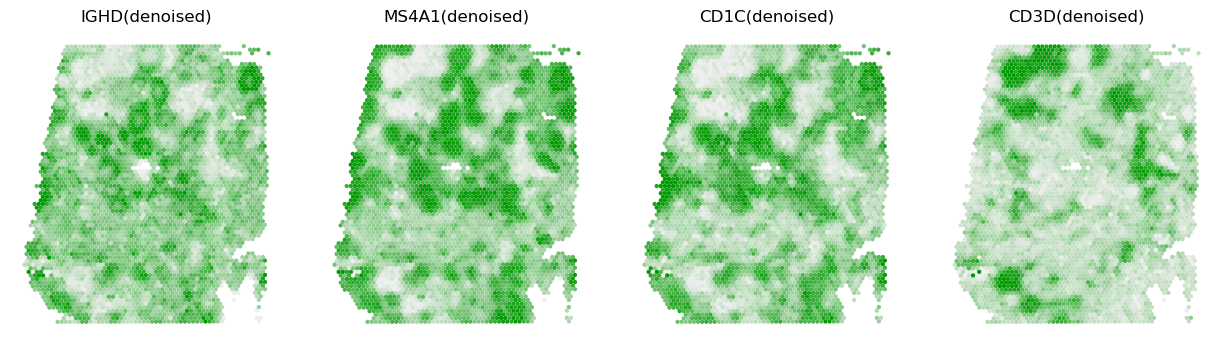

In [10]:
fig, axes = plt.subplots(1,len(list_genes),figsize=(4*(len(list_genes)),4*1))
axes = axes.ravel()

for i in range(len(list_genes)):
    gene = list_genes[i]
    sc.pl.spatial(adata, color=f'{gene}(denoised)', ax=axes[i], vmax='p99', vmin='p1', alpha_img=0, cmap=newcmp, colorbar_loc=None, size=1.6, show=False)
    
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.subplots_adjust(wspace=0, hspace=0)

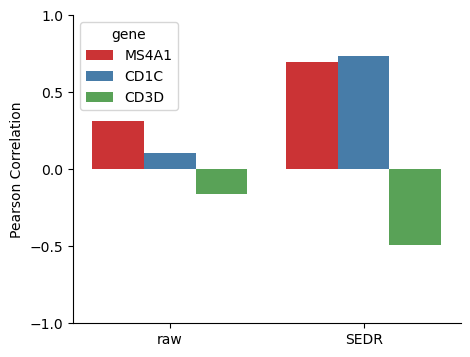

In [21]:
list_idx = []
list_markers = ['IGHD', 'MS4A1', 'CD1C','CD3D']
for gene in list_markers:
    list_idx.append(adata.var.index.tolist().index(gene))

list_corr_raw = np.corrcoef(adata.X[:, list_idx].T)[0, 1:]
list_corr_denoised = adata.obs[[f'{gene}(denoised)' for gene in list_markers]].corr().iloc[0, 1:]

results = [
    ['raw', 'MS4A1', list_corr_raw[0]],
    ['raw', 'CD1C', list_corr_raw[1]],
    ['raw', 'CD3D', list_corr_raw[2]],
    ['SEDR', 'MS4A1', list_corr_denoised[0]], 
    ['SEDR', 'CD1C', list_corr_denoised[1]],
    ['SEDR', 'CD3D', list_corr_denoised[2]],
]

df_results = pd.DataFrame(data=results, columns=['method','gene','corr'])


fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(data=df_results, x='method', y='corr', hue='gene', order=['raw','SEDR'], palette='Set1')

ax.set_xlabel('')
ax.set_ylabel('Pearson Correlation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([-1, -0.5, 0, 0.5, 1])



## Marker genes for GCs

BCL6, FCER2, and EGR1 are known to mark the GC, naïve B cells in the marginal zone of follicles, and activated B cells outside of follicles, respectively. Here we plot the denoised value of three markers on three GCs. 

In [11]:
list_genes = ['BCL6','FCER2','EGR1']

for gene in list_genes:
    idx = adata.var.index.tolist().index(gene)
    adata.obs[f'{gene}(denoised)'] = adata.obsm['de_feat'][:, idx]

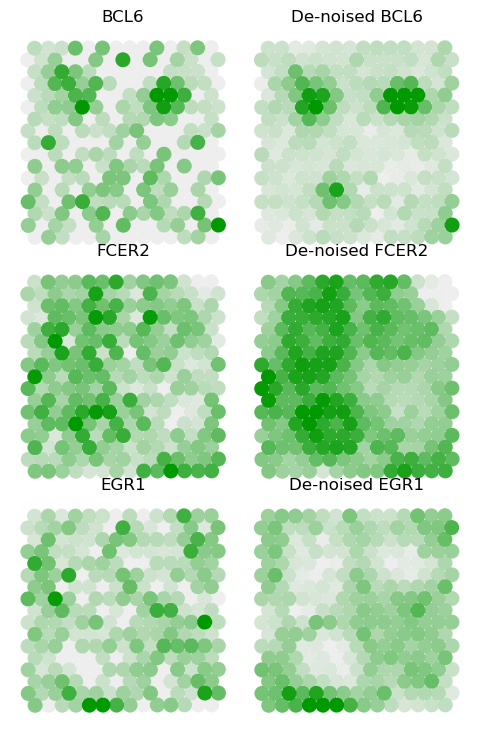

In [12]:
def get_sub(adata):
    sub_adata = adata[
        (adata.obs['array_row'] < 33) & 
        (adata.obs['array_row'] > 15) &
        (adata.obs['array_col'] < 78) & 
        (adata.obs['array_col'] > 48) 
    ]
    return sub_adata

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
newcmp = LinearSegmentedColormap.from_list(
        'new', ['#EEEEEE','#009900'], N=1000)

fig, axes = plt.subplots(3,2,figsize=(3*2,3*3))

_=0

for gene in ['BCL6', 'FCER2','EGR1']:
    i = adata.var.index.tolist().index(gene)

    adata.var['mean_exp'] = adata.X.mean(axis=0)
    sorted_gene = adata.var.sort_values('mean_exp', ascending=False).index
    
    adata.obs['raw'] = adata.X[:, i]
    sub_adata = get_sub(adata)
    sc.pl.spatial(sub_adata, color='raw', ax=axes[_][0], vmax='p99', vmin='p1', alpha_img=0, cmap=newcmp, colorbar_loc=None, size=1.7, show=False)
    axes[_][0].set_title(gene)
    
    adata.obs['recon'] = de_feat[:, i]
    sub_adata = get_sub(adata)
    sc.pl.spatial(sub_adata, color='recon', ax=axes[_][1], vmax='p99', vmin='p1', alpha_img=0, cmap=newcmp, colorbar_loc=None, size=1.7, show=False)
    axes[_][1].set_title(f'De-noised {gene}')
    
    _+=1

for ax in axes.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.subplots_adjust(wspace=0.01, hspace=0.04)